# Project 6

### This project features cluster analysis to identify groups of similar characteristics within the FIFA 2019 dataset.

### In order to do this, it is necessary to extract the most relevant features from the dataset and apply both a partitioning and hierarchical technique to obtain proper segmentation. Principal Component Analysis (PCA) is used as well for visualization matters.

### The purpose of this segmentation is to help a club manager identify players for his team.

##### Dataset used: FIFA 2019


## 1. Exploratory Analysis 

The first thing that has to be done is importing the libraries or packages that will be used throughout the process. And also, to enable a clean visualization of outputs, all warnings will be ignored.

In [37]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.features import PCA
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
warnings.filterwarnings('ignore')

the next step is importing the dataset and take a close look at it.

In [2]:
df = pd.read_csv('asset-v1_IRONHACK+DAFT+201911_SAO+type@asset+block@fifa19.csv')
df.head(2)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M


In [3]:
df.shape

(18207, 89)

After looking at the shape of the dataset, it is necessary to check the number of missing cells in order to evaluate the best way to deal with the information.

In [4]:
preview = list(zip(df.count().index,df.count().values))
print(preview)

[('Unnamed: 0', 18207), ('ID', 18207), ('Name', 18207), ('Age', 18207), ('Photo', 18207), ('Nationality', 18207), ('Flag', 18207), ('Overall', 18207), ('Potential', 18207), ('Club', 17966), ('Club Logo', 18207), ('Value', 18207), ('Wage', 18207), ('Special', 18207), ('Preferred Foot', 18159), ('International Reputation', 18159), ('Weak Foot', 18159), ('Skill Moves', 18159), ('Work Rate', 18159), ('Body Type', 18159), ('Real Face', 18159), ('Position', 18147), ('Jersey Number', 18147), ('Joined', 16654), ('Loaned From', 1264), ('Contract Valid Until', 17918), ('Height', 18159), ('Weight', 18159), ('LS', 16122), ('ST', 16122), ('RS', 16122), ('LW', 16122), ('LF', 16122), ('CF', 16122), ('RF', 16122), ('RW', 16122), ('LAM', 16122), ('CAM', 16122), ('RAM', 16122), ('LM', 16122), ('LCM', 16122), ('CM', 16122), ('RCM', 16122), ('RM', 16122), ('LWB', 16122), ('LDM', 16122), ('CDM', 16122), ('RDM', 16122), ('RWB', 16122), ('LB', 16122), ('LCB', 16122), ('CB', 16122), ('RCB', 16122), ('RB', 161

Since the purpose of this analysis is helping a club manager to find players for his team, there are certain features that have to be regarded as relevant at this point. For this particular study, the release clause is a very important matter, among others, of course.

In addition to that, there can be observed that many of the columns have redundant information. For instance, there is a column named position, and there are over two dozen columns with information on each position. Therefore, the Position column can very well summarize the information contained in the other columns.

By doing this, in order to come up with a good selection of players, the features to be analyzed will be: Age, Potential, Position, Ball Control, Dribbling ,Strength , Sprint Speed,  Acceleration, Reactions, Composure, and Release Clause.

## 2. Data Transformation

At this stage, there are several things that need to be done. 

First of all, it is necessary to select the columns that will be manipulated. 

In [5]:
X = df[['Age', 'Potential','Position','BallControl','Dribbling',
        'Strength','SprintSpeed','Acceleration', 'Reactions','Composure','Release Clause']]
X.head(5)

,Age,Potential,Position,BallControl,Dribbling,Strength,SprintSpeed,Acceleration,Reactions,Composure,Release Clause
0,31,94,RF,96.0,97.0,59.0,86.0,91.0,95.0,96.0,€226.5M
1,33,94,ST,94.0,88.0,79.0,91.0,89.0,96.0,95.0,€127.1M
2,26,93,LW,95.0,96.0,49.0,90.0,94.0,94.0,94.0,€228.1M
3,27,93,GK,42.0,18.0,64.0,58.0,57.0,90.0,68.0,€138.6M
4,27,92,RCM,91.0,86.0,75.0,76.0,78.0,91.0,88.0,€196.4M


In [6]:
preview = list(zip(X.count().index,X.count().values))
preview

[('Age', 18207),
 ('Potential', 18207),
 ('Position', 18147),
 ('BallControl', 18159),
 ('Dribbling', 18159),
 ('Strength', 18159),
 ('SprintSpeed', 18159),
 ('Acceleration', 18159),
 ('Reactions', 18159),
 ('Composure', 18159),
 ('Release Clause', 16643)]

Since there are missing values in the dataset (specially concerning Release Clause) the next step is dropping the rows where there is no information for this feature. Also, converting all values to plain numbers makes it easier to handle the information. 

In [7]:
X = X.dropna()
X['Release Clause'].replace('€','',regex=True, inplace=True)
X['Release Clause'].replace('K','000',regex=True, inplace=True)
X['Release Clause'].replace('M','',regex=True, inplace=True)
price = []
for i in X['Release Clause']:
    i = float(i)
    if i < 1000:
        i = i*1000000
        i = int(i)
    else:
        i = i*1
        i = int(i)
    price.append(i)             
X['Release Clause'] = price
X.head(5)

,Age,Potential,Position,BallControl,Dribbling,Strength,SprintSpeed,Acceleration,Reactions,Composure,Release Clause
0,31,94,RF,96.0,97.0,59.0,86.0,91.0,95.0,96.0,226500000
1,33,94,ST,94.0,88.0,79.0,91.0,89.0,96.0,95.0,127100000
2,26,93,LW,95.0,96.0,49.0,90.0,94.0,94.0,94.0,228100000
3,27,93,GK,42.0,18.0,64.0,58.0,57.0,90.0,68.0,138600000
4,27,92,RCM,91.0,86.0,75.0,76.0,78.0,91.0,88.0,196400000


Next, it is necessary to classify the Positions into smaller groups to have a better understanding of this feature, and hence improve the model's input.

In [8]:
print(X['Position'].value_counts())

ST     1924
GK     1900
CB     1646
CM     1276
LB     1223
RB     1199
RM     1022
LM     1012
CAM     877
CDM     873
RCB     615
LCB     595
RCM     355
LCM     353
LW      338
RW      325
RDM     228
LDM     224
LS      184
RS      179
RWB      84
LWB      76
CF       66
RAM      21
LAM      20
LF       15
RF       13
Name: Position, dtype: int64


In [9]:
global_position = [] 
for q in X['Position']:
    if (q == 'ST') or (q == 'CF') or (q == 'LW') or (q == 'RW') or (q == 'LS') or (q == 'RS') or (q == 'LF') or (q == 'RF'):
        global_position.append('FW')
    elif (q == 'CM') or (q == 'LDM') or (q == 'LAM') or (q == 'RDM') or (q == 'RAM') or (q == 'CDM') or (q == 'CAM') or (q == 'LM') or (q == 'RM') or (q == 'LCM') or (q == 'RCM'):
        global_position.append('MF')
    elif (q == 'CB') or (q == 'LCB') or (q == 'RCB') or (q == 'LCB') or (q == 'LB') or (q == 'RB') or (q == 'LWB') or (q == 'RWB'):
        global_position.append('DF')
    else:
        global_position.append('GK')
X['Position'] = global_position  
X.head(5)        

,Age,Potential,Position,BallControl,Dribbling,Strength,SprintSpeed,Acceleration,Reactions,Composure,Release Clause
0,31,94,FW,96.0,97.0,59.0,86.0,91.0,95.0,96.0,226500000
1,33,94,FW,94.0,88.0,79.0,91.0,89.0,96.0,95.0,127100000
2,26,93,FW,95.0,96.0,49.0,90.0,94.0,94.0,94.0,228100000
3,27,93,GK,42.0,18.0,64.0,58.0,57.0,90.0,68.0,138600000
4,27,92,MF,91.0,86.0,75.0,76.0,78.0,91.0,88.0,196400000


In [10]:
X['Position'].value_counts()

MF    6261
DF    5438
FW    3044
GK    1900
Name: Position, dtype: int64

In [11]:
X.shape

(16643, 11)

In [12]:
X.dtypes

Age                 int64
Potential           int64
Position           object
BallControl       float64
Dribbling         float64
Strength          float64
SprintSpeed       float64
Acceleration      float64
Reactions         float64
Composure         float64
Release Clause      int64
dtype: object

And last but not least, it is a good procedure to make all the data the same type of data. For this particular case, all the information will be set to integers.

In [13]:
X[['BallControl','Dribbling','Strength','SprintSpeed','Acceleration', 'Reactions','Composure','Release Clause']] = X[['BallControl','Dribbling','Strength','SprintSpeed','Acceleration', 'Reactions','Composure','Release Clause']].astype(np.int64)
labelencoder = LabelEncoder()
A = X[['Position']]
A = A.apply(lambda A: labelencoder.fit_transform(A))
A = A.astype(np.int64)
X[['Position']] = A
X.dtypes

Age               int64
Potential         int64
Position          int64
BallControl       int64
Dribbling         int64
Strength          int64
SprintSpeed       int64
Acceleration      int64
Reactions         int64
Composure         int64
Release Clause    int64
dtype: object

The following dataframe will be used for clustering:

In [14]:
X

,Age,Potential,Position,BallControl,Dribbling,Strength,SprintSpeed,Acceleration,Reactions,Composure,Release Clause
0,31,94,1,96,97,59,86,91,95,96,226500000
1,33,94,1,94,88,79,91,89,96,95,127100000
2,26,93,1,95,96,49,90,94,94,94,228100000
3,27,93,2,42,18,64,58,57,90,68,138600000
4,27,92,3,91,86,75,76,78,91,88,196400000
...,...,...,...,...,...,...,...,...,...,...,...
18202,19,65,3,43,42,47,57,54,49,45,143000
18203,19,63,1,40,39,67,39,41,40,42,113000
18204,16,67,1,44,45,32,69,70,47,41,165000
18205,17,66,1,52,51,48,60,61,21,46,143000


## 3. Modeling Segmentation

Now, it is time to normalize the data. 

In [15]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### 3.1 Kmeans

Since the data has been normalized, there are a couple of tools that help when it comes to selecting the right number of clusters for segmentation. These tools make part of a package named Yellowbrick, which aid in this aspect. 

The following code features the elbow method to determine the right number of clusters:

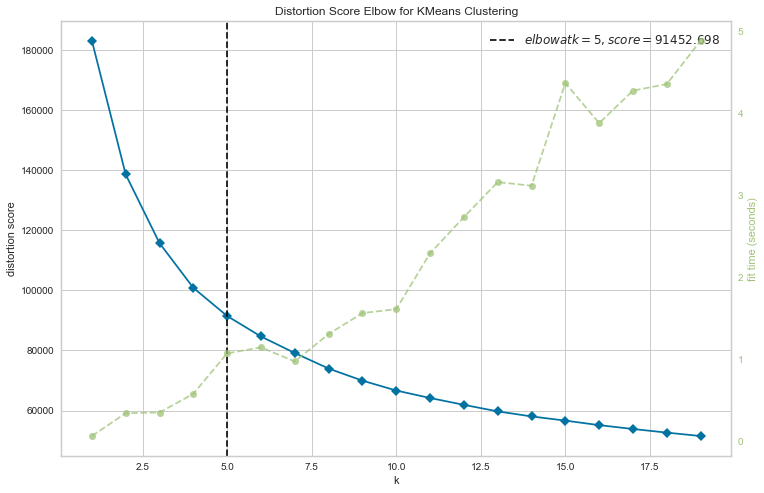

In [16]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
plt.figure(figsize=(12,8))
visualizer.fit(X_std)        
visualizer.show()        

With this information, it is possible to determine that the <b>optimal number of clusters</b> to characterize this dataset is <b>5</b>. 

### 3.2 Silhouette Visualizer

However, the Silhouette Visualizer can be a good option to determine the number of clusters as well, by considering the average score:

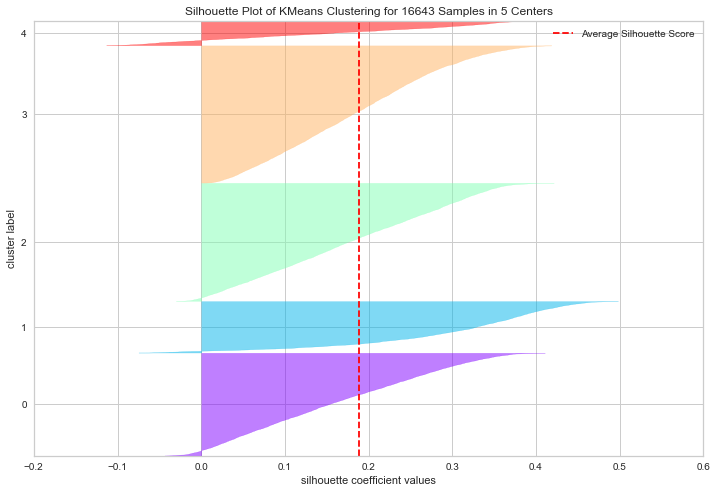

In [17]:
model = KMeans(5).fit(X_std)
visualizer = SilhouetteVisualizer(model, colors='rainbow')
plt.figure(figsize=(12,8))
visualizer.fit(X_std)       
visualizer.show()       

In [18]:
visualizer.silhouette_score_

0.18793144594816738

This silhouette score value (~0.188) determines that 5 clusters are indeed a good number.

## 4. Segmentation using KMeans and applying PCA

Previously, it was determined by the elbow visualizer that the number of optimal clusters for this dataset was 5. Therefore, this number will be the setting for this parameter. The procedure to do this is as follows:

In [19]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Now, there are labels for each cluster:

In [20]:
kmeans.labels_ 

array([1, 1, 1, ..., 2, 2, 2])

And there are cluster centroids as well:

In [21]:
kmeans.cluster_centers_

array([[ 0.22219853,  0.22973251,  0.41487986,  0.65829356,  0.69307409,
        -0.02823878,  0.57861162,  0.60611184,  0.50912949,  0.59801139,
        -0.01744497],
       [ 0.07227614,  1.92731039,  0.08589461,  1.10484147,  0.99357042,
         0.43681164,  0.62534179,  0.60954791,  1.70925942,  1.48465524,
         2.77973396],
       [-0.9005202 , -0.24375139,  0.0258533 , -0.06763097,  0.06553467,
        -0.66804224,  0.27402334,  0.31047124, -0.88994026, -0.69481318,
        -0.3466513 ],
       [ 0.64828129, -0.40091362, -0.77950586,  0.00505826, -0.22026223,
         0.88192766, -0.40328537, -0.48431242,  0.07311837,  0.18854492,
        -0.22626635],
       [ 0.14676045, -0.32964046,  0.28206829, -2.24406481, -2.14373985,
        -0.35254208, -1.75241835, -1.74415735, -0.42249643, -1.21260343,
        -0.22192901]])

The 5 clusters contain the following number of elements:

In [22]:
Counter(kmeans.labels_)

Counter({1: 1054, 3: 3816, 4: 1962, 0: 5338, 2: 4473})

By applying PCA, it is possible to visualize the distribution of these clusters: 

PCA(alpha=0.75,
    ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000207543788C8>,
    classes=None, colorbar=True, colormap=None, colors=None, features=None,
    heatmap=False, proj_features=False, projection=2, random_state=None,
    scale=True)

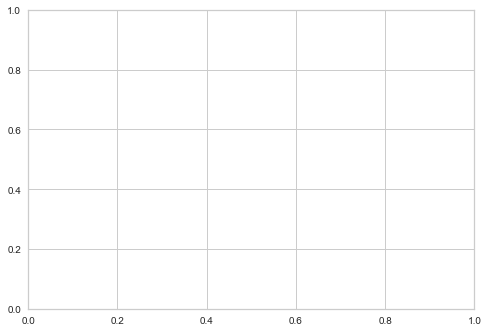

In [23]:
pca = PCA(n_components=2)
pca.fit(X_std)

The next step is identifying the 2 principal components and generating a dataframe.

In [24]:
pc1 = pca.transform(X_std)[:, 0]
pc2 = pca.transform(X_std)[:, 1]
X1 = pd.DataFrame({'pc1': pc1, 'pc2':pc2})
X1

,pc1,pc2
0,11.521530,6.088513
1,9.190147,4.928509
2,11.420849,5.035408
3,3.784614,5.536585
4,9.518696,5.686842
...,...,...
16638,-2.478274,-1.845216
16639,-3.830801,-0.653420
16640,-2.010005,-3.273928
16641,-2.790512,-3.324745


And plot both the PCA, and the PCA with the Kmeans to visualize the clusters:

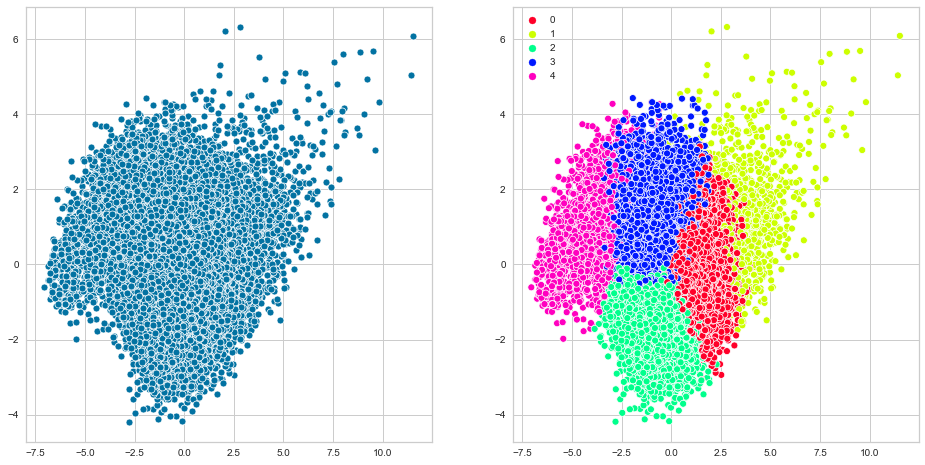

In [25]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.scatterplot(pc1,pc2, ax= ax[0])
sns.scatterplot(pc1,pc2, hue=kmeans.labels_, palette='gist_rainbow', ax= ax[1], legend= 'full')

In [26]:
XC = X.copy()
XC['Cluster'] = kmeans.labels_

In [27]:
XC.groupby(['Cluster','Position']).max()

Age  Potential  BallControl  Dribbling  Strength  \
Cluster Position                                                     
0       0          37         86           83         84        88   
        1          38         88           84         88        93   
        3          38         89           84         85        92   
1       0          37         92           92         90        94   
        1          37         94           96         97        95   
        2          33         93           48         30        80   
        3          35         95           94         93        92   
2       0          33         85           72         73        84   
        1          30         88           74         78        84   
        3          33         87           75         81        86   
3       0          39         85           78         75        95   
        1          39         80           81         76        97   
        2          45         88           42         32        80   
        3          39         81           79         73        93   
4       0          38         79           48         43        91   
        1          19         63           40         39        67   
        2          42         91           40         32        85   
        3          34         69           57         49        92   

                  SprintSpeed  Acceleration  Reactions  Composure  \
Cluster Position                                                    
0       0                  94            93         82         84   
        1                  94            95         83         84   
        3                  95            96         83         86   
1       0                  93            94         88         91   
        1                  96            97         96         96   
        2                  64            65         90         70   
        3                  96            97         93         93   
2       0                  92            92         68         69   
        1                  94            95         70         69   
        3                  94            94         73         69   
3       0                  91            86         84         87   
        1                  84            82         84         86   
        2                  60            67         80         70   
        3                  77            72         80         82   
4       0                  76            65         70         64   
        1                  39            41         40         42   
        2                  65            65         83         71   
        3                  45            53         69         62   

                  Release Clause  
Cluster Position                  
0       0               18900000  
        1               19600000  
        3               21800000  
1       0              121100000  
        1              228100000  
        2              144500000  
        3              196400000  
2       0                5100000  
        1                9100000  
        3                4700000  
3       0               28600000  
        1               17600000  
        2               15100000  
        3               17900000  
4       0                2000000  
        1                 113000  
        2               58400000  
        3                 763000

By looking at the results, it is noticeable that cluster 4 contains the best players overall. Clusters 0 and 1 have good players as well (specially cluster 0). However, they are not as expensive as the ones that belong to cluster 4. 

Clusters 2 and 3 have the cheapest players, and not only that, but they have the worst stats in comparison with the rest.

So far, this segmentation seems to be a good starting point to offer a club manager what he is looking for within his budget.

## 5. Segmentation using Hierarchy and applying PCA

This is a critical type of segmentation, but it can provide great results as well.

For this segmentation method, complete linkage will be used as well as correlation for the metrics.

Complete linkage clustering avoids a drawback of the alternative single linkage method - the so-called <b>chaining phenomenon, where clusters formed via single linkage clustering may be forced together due to single elements being close to each other, even though many of the elements in each cluster may be very distant to each other.</b> Complete linkage tends to find compact clusters of approximately equal diameters.[1]

Correlation metrics measure whether or not there is a relationship between two variables.[2] Since the project deals with soccer players and their performance, it is good to find similar patterns to group them effectively.

References:

1. https://en.wikipedia.org/wiki/Complete-linkage_clustering
2. https://mixpanel.com/topics/correlation-metrics/



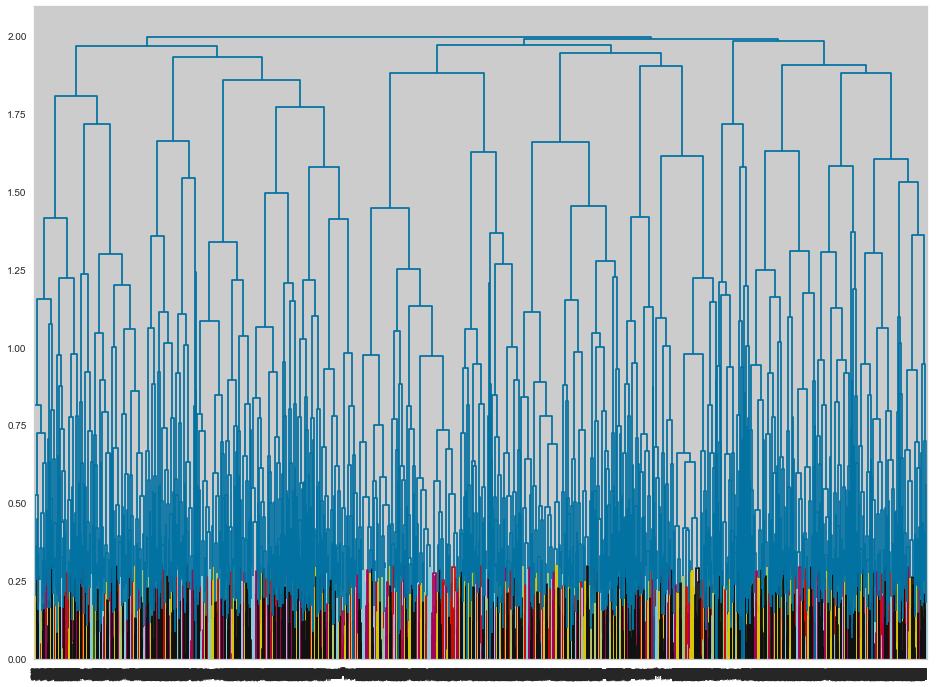

In [28]:
plt.figure(figsize=(16,12))
dendrogram = hierarchy.dendrogram(hierarchy.linkage(StandardScaler().fit_transform(X), 
                                                    metric= 'correlation', method = 'complete'), color_threshold=0.3)

By looking at the dendrogram, if a horizontal line was drawn right below the 2.00 tick mark (between 1.92 and 1.96 approximately), <b>6 clusters would make a good segmentation for this data</b>.

Thus, Agglomerative Clustering can be set with those parameters in order to get a good segmentation considering similar patterns among players.

In [29]:
hierarchical = AgglomerativeClustering(n_clusters=6, affinity='correlation', linkage='complete')
hierarchical.fit(X_std)

AgglomerativeClustering(affinity='correlation', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=6)

In [30]:
Counter(hierarchical.labels_)

Counter({1: 3968, 0: 3652, 4: 3028, 5: 2085, 3: 622, 2: 3288})

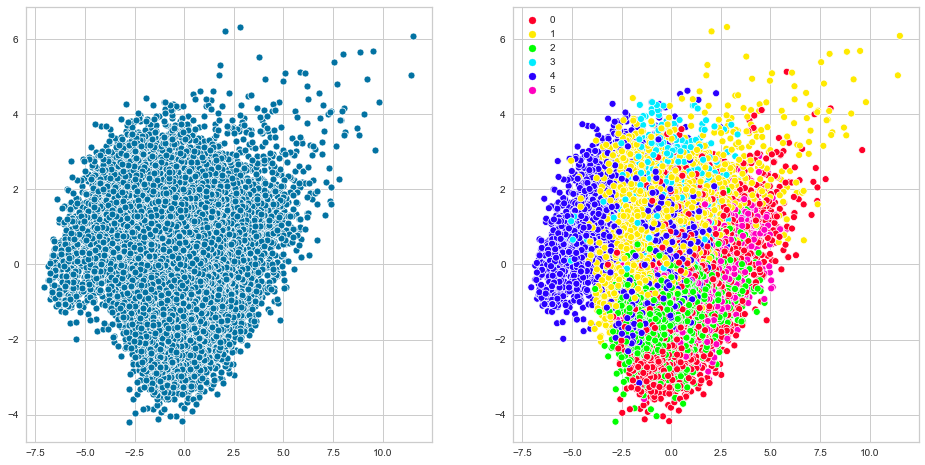

In [31]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.scatterplot(pc1,pc2, ax= ax[0])
sns.scatterplot(pc1,pc2, hue=hierarchical.labels_, palette='gist_rainbow', ax= ax[1], legend='full')

Evidently, it is not easy to visually distinguish clusters. However, by creating a new feature in the dataset, there could be interesting insights in it. 

In [32]:
XH = X.copy()
XH['Hierarchical'] = hierarchical.labels_
XH.groupby(['Hierarchical','Position']).max()

Age  Potential  BallControl  Dribbling  Strength  \
Hierarchical Position                                                     
0            0          33         77           80         76        55   
             1          36         92           93         92        70   
             3          39         95           94         93        91   
1            0          39         92           92         90        95   
             1          39         94           96         97        95   
             2          27         93           42         18        79   
             3          31         92           91         90        92   
2            0          30         88           77         77        90   
             1          30         88           83         89        95   
             3          27         89           87         87        90   
3            0          39         77           71         67        93   
             1          39         77           81         76        97   
             2          24         70           37         22        77   
             3          36         84           85         82        93   
4            1          23         67           58         49        65   
             2          45         93           48         32        85   
             3          39         77           78         79        92   
5            0          35         88           86         85        88   
             1          37         92           92         90        87   
             3          30         81           83         87        77   

                       SprintSpeed  Acceleration  Reactions  Composure  \
Hierarchical Position                                                    
0            0                  78            82         79         84   
             1                  96            94         88         86   
             3                  96            97         91         93   
1            0                  93            93         88         91   
             1                  95            95         96         96   
             2                  60            57         90         70   
             3                  95            94         93         91   
2            0                  92            92         78         83   
             1                  96            97         77         80   
             3                  95            94         79         78   
3            0                  62            59         77         77   
             1                  77            69         84         86   
             2                  59            45         62         62   
             3                  79            78         86         87   
4            1                  55            62         60         55   
             2                  65            67         86         71   
             3                  92            93         78         80   
5            0                  94            94         84         82   
             1                  94            94         88         89   
             3                  91            90         81         77   

                       Release Clause  
Hierarchical Position                  
0            0                7000000  
             1              125100000  
             3              166100000  
1            0              121100000  
             1              228100000  
             2              144500000  
             3              196400000  
2            0               33299999  
             1               34200000  
             3               34200000  
3            0               10900000  
             1               14300000  
             2                 648000  
             3               33000000  
4            1                 630000  
             2               79900000  
             3         

As it can be seen, this type of segmentation is not very effective to see patterns within the clusters. All the information is mostly mixed up.

## 6. Merging Clusters to the Dataframe

This is the last step of the process. Nevertheless, since the original dataset only had information regarding release clauses for 91% of the total number of players, these were the ones who got to be clustered. In other words, if a club manager is willing to assemble a soccer team, every possible player for his team has to have a price. If there is no price for the player, that means that he is out of reach.

With this said, the next step is dropping all rows where there is no release clause:

In [33]:
df = df.dropna(subset=['Release Clause'])

In [34]:
df.shape

(16643, 89)

In [35]:
df['Cluster'] = kmeans.labels_

In [36]:
df.to_csv('fifa_clustered.csv')